In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [25]:
cifar10_train = datasets.CIFAR10(
    root='../data/cifar10_data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
cifar10_test = datasets.CIFAR10(
    root='../data/cifar10_data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [26]:
print(cifar10_train)
print(cifar10_test)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/cifar10_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/cifar10_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [27]:
print(cifar10_train.data.shape)
print(cifar10_train.targets[:10])

(50000, 32, 32, 3)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [28]:
# # 만일 plot과 datasets가 충돌한다면
#
# import os
#
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

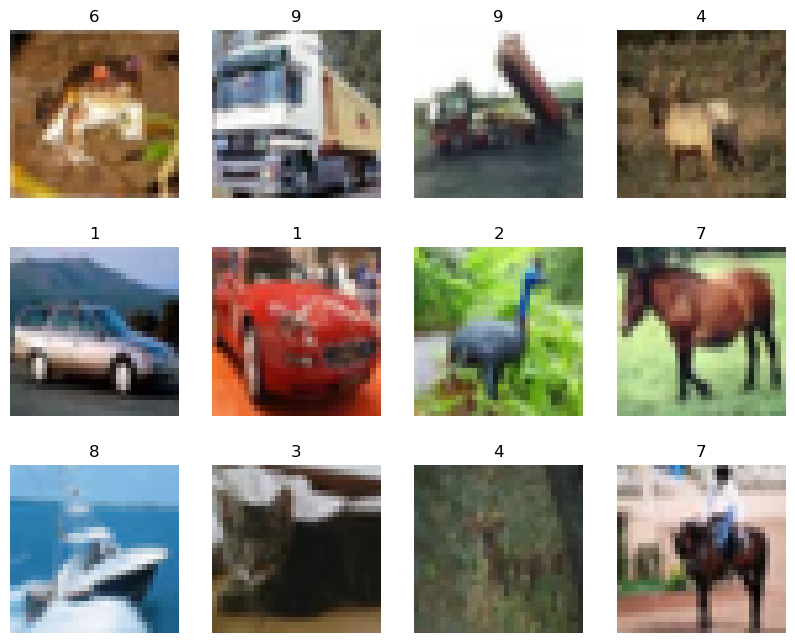

In [29]:
def plot(x, y):
    plt.figure(figsize=(10, 8))

    for i in range(len(x)):
        plt.subplot(3, 4, i+1)
        plt.title(y[i])
        img = np.array(x[i].reshape(32, 32, 3))
        plt.imshow(img)
        plt.axis('off')
    plt.show()

plot(cifar10_train.data[:12], cifar10_train.targets[:12])

In [30]:
print(type(cifar10_train.data))
print(type(cifar10_train.targets))
print(cifar10_train.data.shape) # 4차원 배열 -> 갯수, 가로, 세로, 색깔
# 하지만 파이토치에선 색깔이 가로 세로보다 뒷차원에 있어야 함

<class 'numpy.ndarray'>
<class 'list'>
(50000, 32, 32, 3)


In [43]:
# (row, col, channel) -> (channel, row, col)로 변환
x = torch.FloatTensor(cifar10_train.data).permute(0, 3, 1, 2)
y = torch.LongTensor(cifar10_train.targets)
x_test = torch.FloatTensor(cifar10_test.data).permute(0, 3, 1, 2)
y_test = torch.LongTensor(cifar10_test.targets)

print(x.size())

torch.Size([50000, 3, 32, 32])


In [35]:
x = (x.float() / 255).view(x.size(0), -1)
input_size = x.size(-1)
output_size = len(np.unique(y))
print(input_size)
print(output_size)

3072
10


In [53]:
train_cnt = int(x.size(0) * 0.8)
valid_cnt = int(x.size(0) * 0.2)
test_cnt = len(cifar10_test.data)
cnts = [train_cnt, valid_cnt]
print(cnts)

indices = torch.randperm(x.size(0))
x_shuffle = torch.index_select(x, dim=0, index=indices)
y_shuffle = torch.index_select(y, dim=0, index=indices)
x_shuffle = (x_shuffle.float() / 255).view(len(x_shuffle), -1)

x_split = list(x_shuffle.split(cnts, dim=0))
y_split = list(y_shuffle.split(cnts, dim=0))
print(x_split[0].shape)
print(x_split[1].shape)
print(y_split[0].shape)
print(y_split[1].shape)

x_split += [(x_test.float() / 255).view(test_cnt, -1)]
y_split += [y_test]

print()

for x_i, y_i in zip(x_split, y_split):
    print(x_i.size())
    print(y_i.size())

[40000, 10000]
torch.Size([40000, 3072])
torch.Size([10000, 3072])
torch.Size([40000])
torch.Size([10000])

torch.Size([40000, 3072])
torch.Size([40000])
torch.Size([10000, 3072])
torch.Size([10000])
torch.Size([10000, 3072])
torch.Size([10000])


In [54]:
model = nn.Sequential(
    nn.Linear(input_size, 800),
    nn.LeakyReLU(),
    nn.Linear(800, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs = 1000
batch_size = 256
early_stop = 50
lowest_loss = np.inf
lowest_epoch = np.inf

train_history, valid_history = [], []

In [55]:
for epoch in range(epochs + 1):
    x_ = x_split[0].split(batch_size, dim=0)
    y_ = y_split[0].split(batch_size, dim=0)

    train_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = criterion(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    train_loss /= len(x_)

    with torch.no_grad():
        x_ = x_split[1].split(batch_size, dim=0)
        y_ = y_split[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = criterion(y_hat_i, y_i.squeeze())

            valid_loss += float(loss)
        valid_loss /= len(x_)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Lowest Valid Loss: {lowest_loss:.4f}')

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = epoch
        best_model = deepcopy(model.state_dict())
    else:
        if (early_stop > 0) and (lowest_epoch + early_stop < epoch):
            print(f'{lowest_epoch} 이후 {early_stop} epoch 증가하는 동안 손실함수 감소 없음')
            break

print(f'epoch {lowest_epoch}일 때 최소 손실함수: {lowest_loss}')

Epoch: 0 | Train Loss: 2.0170 | Valid Loss: 1.8430 | Lowest Valid Loss: inf
Epoch: 10 | Train Loss: 1.3477 | Valid Loss: 1.4468 | Lowest Valid Loss: 1.4725
Epoch: 20 | Train Loss: 1.1274 | Valid Loss: 1.5889 | Lowest Valid Loss: 1.4466
Epoch: 30 | Train Loss: 0.9358 | Valid Loss: 1.7550 | Lowest Valid Loss: 1.4466
Epoch: 40 | Train Loss: 0.8145 | Valid Loss: 2.0178 | Lowest Valid Loss: 1.4466
Epoch: 50 | Train Loss: 0.6948 | Valid Loss: 2.0908 | Lowest Valid Loss: 1.4466
Epoch: 60 | Train Loss: 0.6192 | Valid Loss: 2.5522 | Lowest Valid Loss: 1.4466
12 이후 50 epoch 증가하는 동안 손실함수 감소 없음
epoch 12일 때 최소 손실함수: 1.4466464191675186


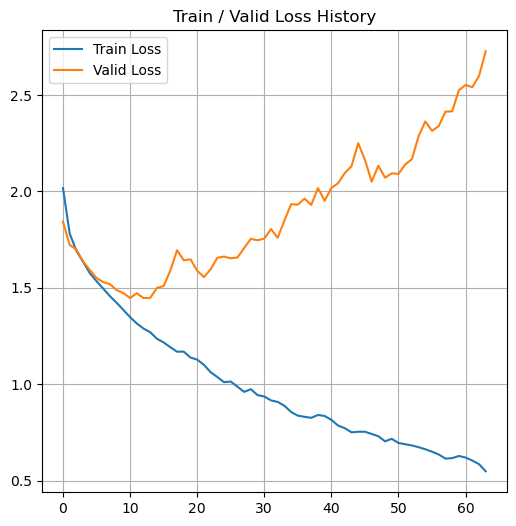

In [56]:
plot_from = 0

plt.figure(figsize=(6, 6))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train Loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid Loss')
plt.legend()
plt.show()

In [60]:
test_loss = 0
y_hat_list = []

with torch.no_grad():
    x_ = x_split[2].split(batch_size, dim=0)
    y_ = y_split[2].split(batch_size, dim=0)
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = criterion(y_hat_i, y_i)
        test_loss += loss
        y_hat_list += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat_list = torch.cat(y_hat_list, dim=0)

print('Test Loss:', test_loss.item())

correct_cnt = (y_split[-1] == torch.argmax(y_hat_list, dim=-1)).sum()
print(correct_cnt / 10000)

Test Loss: 2.636331081390381
tensor(0.4655)


In [61]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(confusion_matrix(y_split[-1], torch.argmax(y_hat_list, dim=-1)),)

,0,1,2,3,4,5,6,7,8,9
0,487,67,52,28,35,10,24,9,206,82
1,30,623,18,26,17,15,12,10,56,193
2,86,31,327,115,161,73,92,39,46,30
3,53,28,85,340,71,138,125,40,60,60
4,54,21,118,100,425,33,121,52,46,30
5,35,21,89,284,64,251,75,58,62,61
6,15,35,74,115,114,46,515,24,24,38
7,45,38,57,88,110,58,30,443,21,110
8,72,88,13,30,23,6,8,8,664,88
9,32,196,18,26,12,12,26,25,73,580
